# Machine Learning Project Air Pollution 17.12.23

## Problem Description
### Introduction

In a world increasingly influenced by the consequences of climate change, its impacts are particularly noticeable in cities and metropolitan areas. While the causes of global warming are diverse, it has far-reaching effects on human health and nature. Another critical aspect of this development is the increasing air pollution in densely populated residential areas.


### Problem Statement
For this reason, we want to address the increased air pollution in the city of Zurich. [A key element of air pollution](https://www.bafu.admin.ch/dam/bafu/de/dokumente/luft/fachinfo-daten/feinstaub_fragenundantworten.pdf) is the fine dust particle PM2.5, which poses serious health risks to the Zurich population in elevated concentrations. Therefore, the need to effectively monitor the dynamics and occurrence of PM2.5 becomes an urgent concern in the context of cantonal health care and environmental planning.


### Project Objective
Our goal is to develop a machine learning model that can predict the concentration of PM2.5. Our model aims to help identify potential danger situations for the population of the city of Zurich by providing predictions about air quality. Thanks to this early detection of elevated PM2.5 levels, measures can be taken to minimize health risks to people.


### Implementation
Our model will be trained on existing environmental data from the city of Zurich and be able to make predictions about air quality. This will not only develop a better understanding of the dynamics of air pollution but also support measures to protect the health of the population in Zurich.

## Description of the Dataframes:

##### Meteorological, Traffic, and Air Pollution Data from Zurich Sources:

- [Air Pollutant Measurement (Hourly Values) - City of Zurich](https://data.stadt-zuerich.ch/dataset/ugz_luftschadstoffmessung_stundenwerte)

- [Meteorological Data (Hourly Averages) - City of Zurich](https://data.stadt-zuerich.ch/dataset/ugz_meteodaten_stundenmittelwerte)

- [Traffic Counting - City of Zurich](https://data.stadt-zuerich.ch/dataset/sid_dav_verkehrszaehlung_miv_od2031)

<details>
<summary>Air Pollution</summary>

| Description | Attribute Name |
| --- | --- |
| Start time of the measurement period in winter time (UTC+1), ISO format | Datum |
| Location of measurement, defined in the metadata | Standort |
| Measured pollutant, defined in the metadata | Parameter |
| Measurement interval/averaging period (h1: 1 hour, d1: 1 day, y1: 1 year) | Intervall |
| Unit of the measured parameter | Einheit |
| Measurement value of the measured parameter | Wert |
| Status of the value ("provisional" or "corrected") | Status |

</details>

<details>
<summary>Traffic</summary>

| Description | Attribute Name |
| --- | --- |
| Identification number of the measuring station | MSID |
| Name of the measuring station | MSName |
| Identification number of the counting station | ZSID |
| Name of the counting station | ZSName |
| Axis (road) of the measuring station | Achse |
| House number | HNr |
| Height of the axis (designation) | Hoehe |
| East coordinate (CH1903+/LV95) | EKoord |
| North coordinate (CH1903+/LV95) | NKoord |
| Direction of the measurement | Richtung |
| Identification number of the group | Knummer |
| Name of the group | Kname |
| Number of detectors | AnzDetektoren |
| Detector 1 of the measuring station | D1ID |
| Detector 2 of the measuring station | D2ID |
| Detector 3 of the measuring station | D3ID |
| Detector 4 of the measuring station | D4ID |
| Date and time of the measurement | MessungDatZeit |
| Date of delivery | LieferDat |
| Number of vehicles | AnzFahrzeuge |
| Status of the measurement | AnzFahrzeugeStatus |

</details>

<details>
<summary>Meteo</summary>

| Description | Attribute Name |
| --- | --- |
| Start time of the measurement period in winter time (UTC+1), ISO format | Datum |
| Location of measurement, defined in the metadata | Standort |
| Measured parameter, defined in the metadata | Parameter |
| Measurement interval/averaging period (h1: 1 hour, d1: 1 day, y1: 1 year) | Intervall |
| Unit of the measured parameter | Einheit |
| Measurement value of the measured parameter | Wert |
| Status of the value ("provisional" or "corrected") | Status |

</details>


In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import requests
import datetime as dt
import numpy as np
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import learning_curve
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from skopt import BayesSearchCV
from sklearn.model_selection import cross_validate
from sklearn.tree import DecisionTreeRegressor
from joblib import dump, load

In [362]:
# Global Parameters

GET_NEW_DATA = True                     # Set to True if you want to get the newest data            
START_YEAR = 2018                       # Set the start year to get data (Can't be older than 2018, beacuse there is not enough Data before)
CURRENT_YEAR = dt.date.today().year     # Get the current year
RUN_MODEL_OPTIMIZATION = True           # Set to True if you have time ;)

## Locations

Following our research and analysis of the available measuring stations, we have selected the stations Stampfenbachstrasse and Schimmelstrasse. These stations were the only ones in the city of Zurich that met all our requirements. Another factor for the selection of these stations was their availability in all relevant datasets, which makes it easier for us to conduct analyses without having to significantly manipulate or falsify the data.

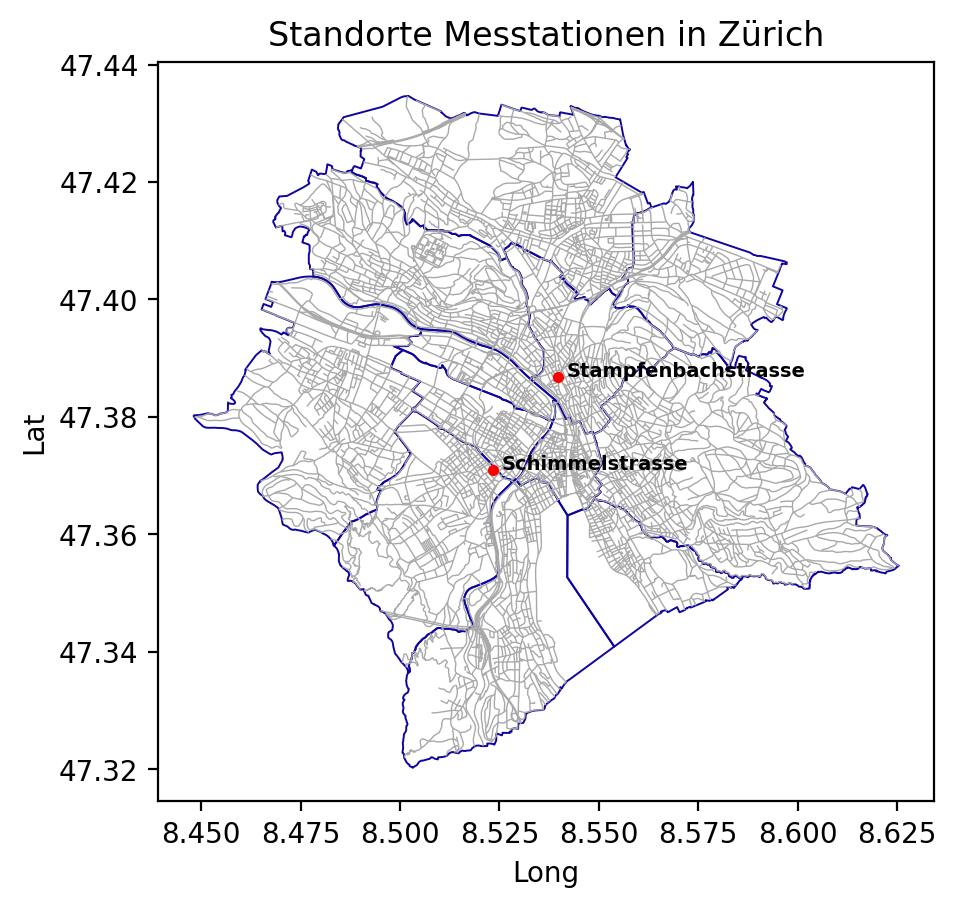

In [363]:
# Set the figure dpi
mpl.rcParams['figure.dpi'] = 200

# Define URLs for GeoJSON data
city_districts_url = 'https://www.ogd.stadt-zuerich.ch/wfs/geoportal/Stadtkreise?service=WFS&version=1.1.0&request=GetFeature&outputFormat=GeoJSON&typename=adm_stadtkreise_a'
city_streets_url = 'https://www.ogd.stadt-zuerich.ch/wfs/geoportal/Strassennamenverzeichnis?service=WFS&version=1.1.0&request=GetFeature&outputFormat=GeoJSON&typename=sv_str_lin'

# Read the GeoJSON data into GeoDataFrames
zurich_districts = gpd.read_file(city_districts_url)
zurich_streets = gpd.read_file(city_streets_url)

# Plot the map
fig, ax = plt.subplots()

# Plot city districts with white outlines
zurich_districts.plot(ax=ax, facecolor='none', edgecolor='#0f05a0', linewidth=0.7)

# Plot city streets with light grey color and adjust marker size and linewidth
zurich_streets.plot(ax=ax, color='darkgrey', markersize=0.5, linewidth=0.5)

# Plot red points on specific coordinates
plt.plot(8.5398, 47.3868, 'r.', label='Stampfenbachstrasse')
plt.plot(8.5235, 47.3710, 'r.', label='Schimmelstrasse')

# Annotate the points with black text
plt.annotate('Stampfenbachstrasse', (8.5418, 47.3868), fontsize=7, color='k', weight='bold')
plt.annotate('Schimmelstrasse', (8.5255, 47.3710), fontsize=7, color='k', weight='bold')

# Set plot title and labels
plt.title('Standorte Messtationen in Zürich')
plt.xlabel('Long')
plt.ylabel('Lat')

# Show the plot
plt.show()


## Load Data

In [364]:
# Function to load a list of CSV-Files with data

def load_data(data_to_load):
    return pd.concat([pd.read_csv(i, low_memory=False) for i in data_to_load], ignore_index=True)
    

In [365]:
# Load the data from the OpenGov site of Zurich

# Specify the Filepath, where the Data is stored, for offline use:
meteofile_path = f'data\\meteo_data_{START_YEAR}-{CURRENT_YEAR}.csv'
pollutionfile_path = f'data\\pollution_data_{START_YEAR}-{CURRENT_YEAR}.csv'
trafficfile_path = f"data\\traffic_data_{START_YEAR}-{CURRENT_YEAR}.csv"


if GET_NEW_DATA:

    # Create list of csv to load:
    BASE_URL = 'https://data.stadt-zuerich.ch/dataset/'

    meteo_link = [f'{BASE_URL}ugz_meteodaten_stundenmittelwerte/download/ugz_ogd_meteo_h1_{year}.csv' for year in range(START_YEAR, CURRENT_YEAR + 1)]
    pollution_link = [f'{BASE_URL}ugz_luftschadstoffmessung_stundenwerte/download/ugz_ogd_air_h1_{year}.csv' for year in range(START_YEAR, CURRENT_YEAR + 1)]
    traffic_link = [f'{BASE_URL}sid_dav_verkehrszaehlung_miv_od2031/download/sid_dav_verkehrszaehlung_miv_OD2031_{year}.csv' for year in range (START_YEAR, CURRENT_YEAR + 1)]

    weather_data = load_data(meteo_link)
    pollution_data = load_data(pollution_link)
    traffic_data = load_data(traffic_link)


    weather_data.to_csv(meteofile_path, index=False)
    pollution_data.to_csv(pollutionfile_path, index=False)
    traffic_data.to_csv(trafficfile_path, index=False)

    print('Data updated')

else:

    # Get the data from the local repository:
    weather_data = pd.read_csv(meteofile_path, low_memory=False)
    pollution_data = pd.read_csv(pollutionfile_path, low_memory=False)
    traffic_data = pd.read_csv(trafficfile_path, low_memory=False)

    print('Data from local repository')


Data updated


To ensure the reusability and timeliness of the notebook, we have decided to leave it up to the user to determine the time period for which the analysis should be conducted. This should help to ensure that the notebook is always up-to-date with the latest data. The data will be downloaded directly from the OpenGov website and saved.

## Data Cleaning:

In [366]:
# Rename the column names for convenience:

weather_data.Standort = weather_data.Standort.str.replace('Zch_' , '')
pollution_data.Standort = pollution_data.Standort.str.replace('Zch_' , '')

#### Defining the functions to clean the data:

In [2]:
def get_specific_values(dataframe, parameters, standort):
    """
    Extracts an array of values for specified parameters and location (standort) from the given dataframe.
    This function filters the dataframe for each parameter at the specified location,
    then extracts the 'Wert' column values.

    """
    return np.array(
        [
            dataframe[
                (dataframe["Parameter"] == parameter)
                & (dataframe["Standort"] == standort)
            ].Wert
            for parameter in parameters
        ]
    ).T


def extract_data(dataframes, params, standort):
    """
    Combines data from multiple dataframes for a specific location.
    It extracts specific parameter values from each dataframe and then concatenates these into a single dataframe.
    The columns are named accordingly, and the 'date' column is standardized to datetime format without timezone.
    """
    array1 = get_specific_values(dataframes[0], params[0], standort)
    array2 = get_specific_values(dataframes[1], params[1], standort)
    dates = dataframes[0]["Datum"].unique()
    df1 = pd.DataFrame(array1)
    df2 = pd.DataFrame(array2)
    df = pd.concat([df1, df2], axis=1)
    df.columns = ["temp", "raindur", "press", "wind", "PM2.5"]
    df["date"] = pd.to_datetime(dates).tz_localize(None)
    df["location"] = standort
    return df


def get_traffic_data(df, standort, id):
    """
    Extracts and processes traffic data for a specific location and counting station ID.
    The function filters data by location and ID, then organizes it by direction, date, and location.
    """
    data = df[(df["Achse"] == standort) & (df.ZSID == id)]
    sensor = np.array(
        [
            data[data["Richtung"] == richtung].AnzFahrzeuge
            for richtung in data.Richtung.unique()
        ]
    ).T
    zeit = np.array(
        [
            data[data["Richtung"] == richtung].MessungDatZeit
            for richtung in data.Richtung.unique()
        ]
    ).T
    df1 = pd.DataFrame(sensor)
    df2 = pd.DataFrame(zeit)
    finaldf = pd.concat([df1, df2], axis=1)
    finaldf.columns = ["direction_1", "direction_2", "date", "date2"]
    finaldf = finaldf.drop("date2", axis=1)
    finaldf["date"] = pd.to_datetime(finaldf.date)
    finaldf["location"] = standort
    return finaldf


def transform_dates(df):
    """
    Enhances the dataframe by adding separate columns for weekday, hour, day, month, and year.
    """
    df["weekday"] = df["date"].dt.day_name()
    df["hour"] = df["date"].dt.hour
    df["day"] = df["date"].dt.day
    df["month"] = df["date"].dt.month_name()
    df["year"] = df["date"].dt.year
    df = df.drop(columns=["date"])

    return df

The similarity in structure between the weather and pollution datasets simplifies the process of extracting all the data in a unified manner, allowing for a streamlined approach. Due to the inherent differences in data structure, extracting essential information from traffic data requires a distinct function tailored specifically to its unique characteristics.

#### Cleaning the data:

In [368]:
# Defining parameters that need to be extracted

params = [['T', 'RainDur', 'p', 'WVv'],['PM2.5']]
standorte_stations = ['Schimmelstrasse', 'Stampfenbachstrasse' ]  
standorte_id_traffic = {'Schimmelstrasse' : 'Z068', 'Stampfenbachstrasse' : 'Z058'} 

# Exctracting the above definied parameters into two df

weather_Pollution_df = pd.concat([extract_data([weather_data, pollution_data], params, standort) for standort in standorte_stations], ignore_index=True)
traffic_data_filtered = pd.concat([get_traffic_data(traffic_data, keys, values) for keys, values in standorte_id_traffic.items()], ignore_index = True)

In [369]:
# Merging the dataframes into complete dataframe and transforming the date column:

complete_dataframe = pd.merge(weather_Pollution_df, traffic_data_filtered, on= ['date', 'location'], how='outer')
transformed_df = transform_dates(complete_dataframe)

### The final Dataframe:

In [370]:
transformed_df.head(10)

temp  raindur   press  wind  PM2.5         location  direction_1  \
0  9.60     0.00  962.07  0.70  13.75  Schimmelstrasse        341.0   
1  9.53     0.00  962.47  0.99   9.71  Schimmelstrasse        538.0   
2  8.65    25.05  963.84  0.43   8.94  Schimmelstrasse        444.0   
3  7.42    56.22  965.28  1.93   4.66  Schimmelstrasse        344.0   
4  6.65    11.75  965.88  0.44   4.19  Schimmelstrasse        255.0   
5  6.72     0.00  966.30  0.19   4.20  Schimmelstrasse        230.0   
6  6.65     1.22  966.40  0.43   4.39  Schimmelstrasse        188.0   
7  6.62     0.00  966.31  0.84   4.90  Schimmelstrasse        160.0   
8  6.44     0.82  967.00  0.78   5.11  Schimmelstrasse        166.0   
9  5.77     0.00  967.57  0.21   4.81  Schimmelstrasse        236.0   

   direction_2 weekday  hour  day    month  year  
0        339.0  Monday     0    1  January  2018  
1        705.0  Monday     1    1  January  2018  
2        398.0  Monday     2    1  January  2018  
3        281.0  Monday     3    1  January  2018  
4        217.0  Monday     4    1  January  2018  
5        172.0  Monday     5    1  January  2018  
6        157.0  Monday     6    1  January  2018  
7        138.0  Monday     7    1  January  2018  
8        124.0  Monday     8    1  January  2018  
9        147.0  Monday     9    1  January  2018

#### Handling missing values:

In [371]:
missing_vals = len(transformed_df[transformed_df.isnull().any(axis=1)])
print(f'Out of {len(transformed_df)} Datapoints, {missing_vals} contain missing values. That is {round((missing_vals/len(transformed_df))*100, 2)} % of all the Datapoints. We decided to drop them')

Out of 104486 Datapoints, 3124 contain missing values. That is 2.99 % of all the Datapoints. We decided to drop them


In [372]:
transformed_df = transformed_df.dropna()

## Explorative Datenanalyse

### Visualisation by Month 

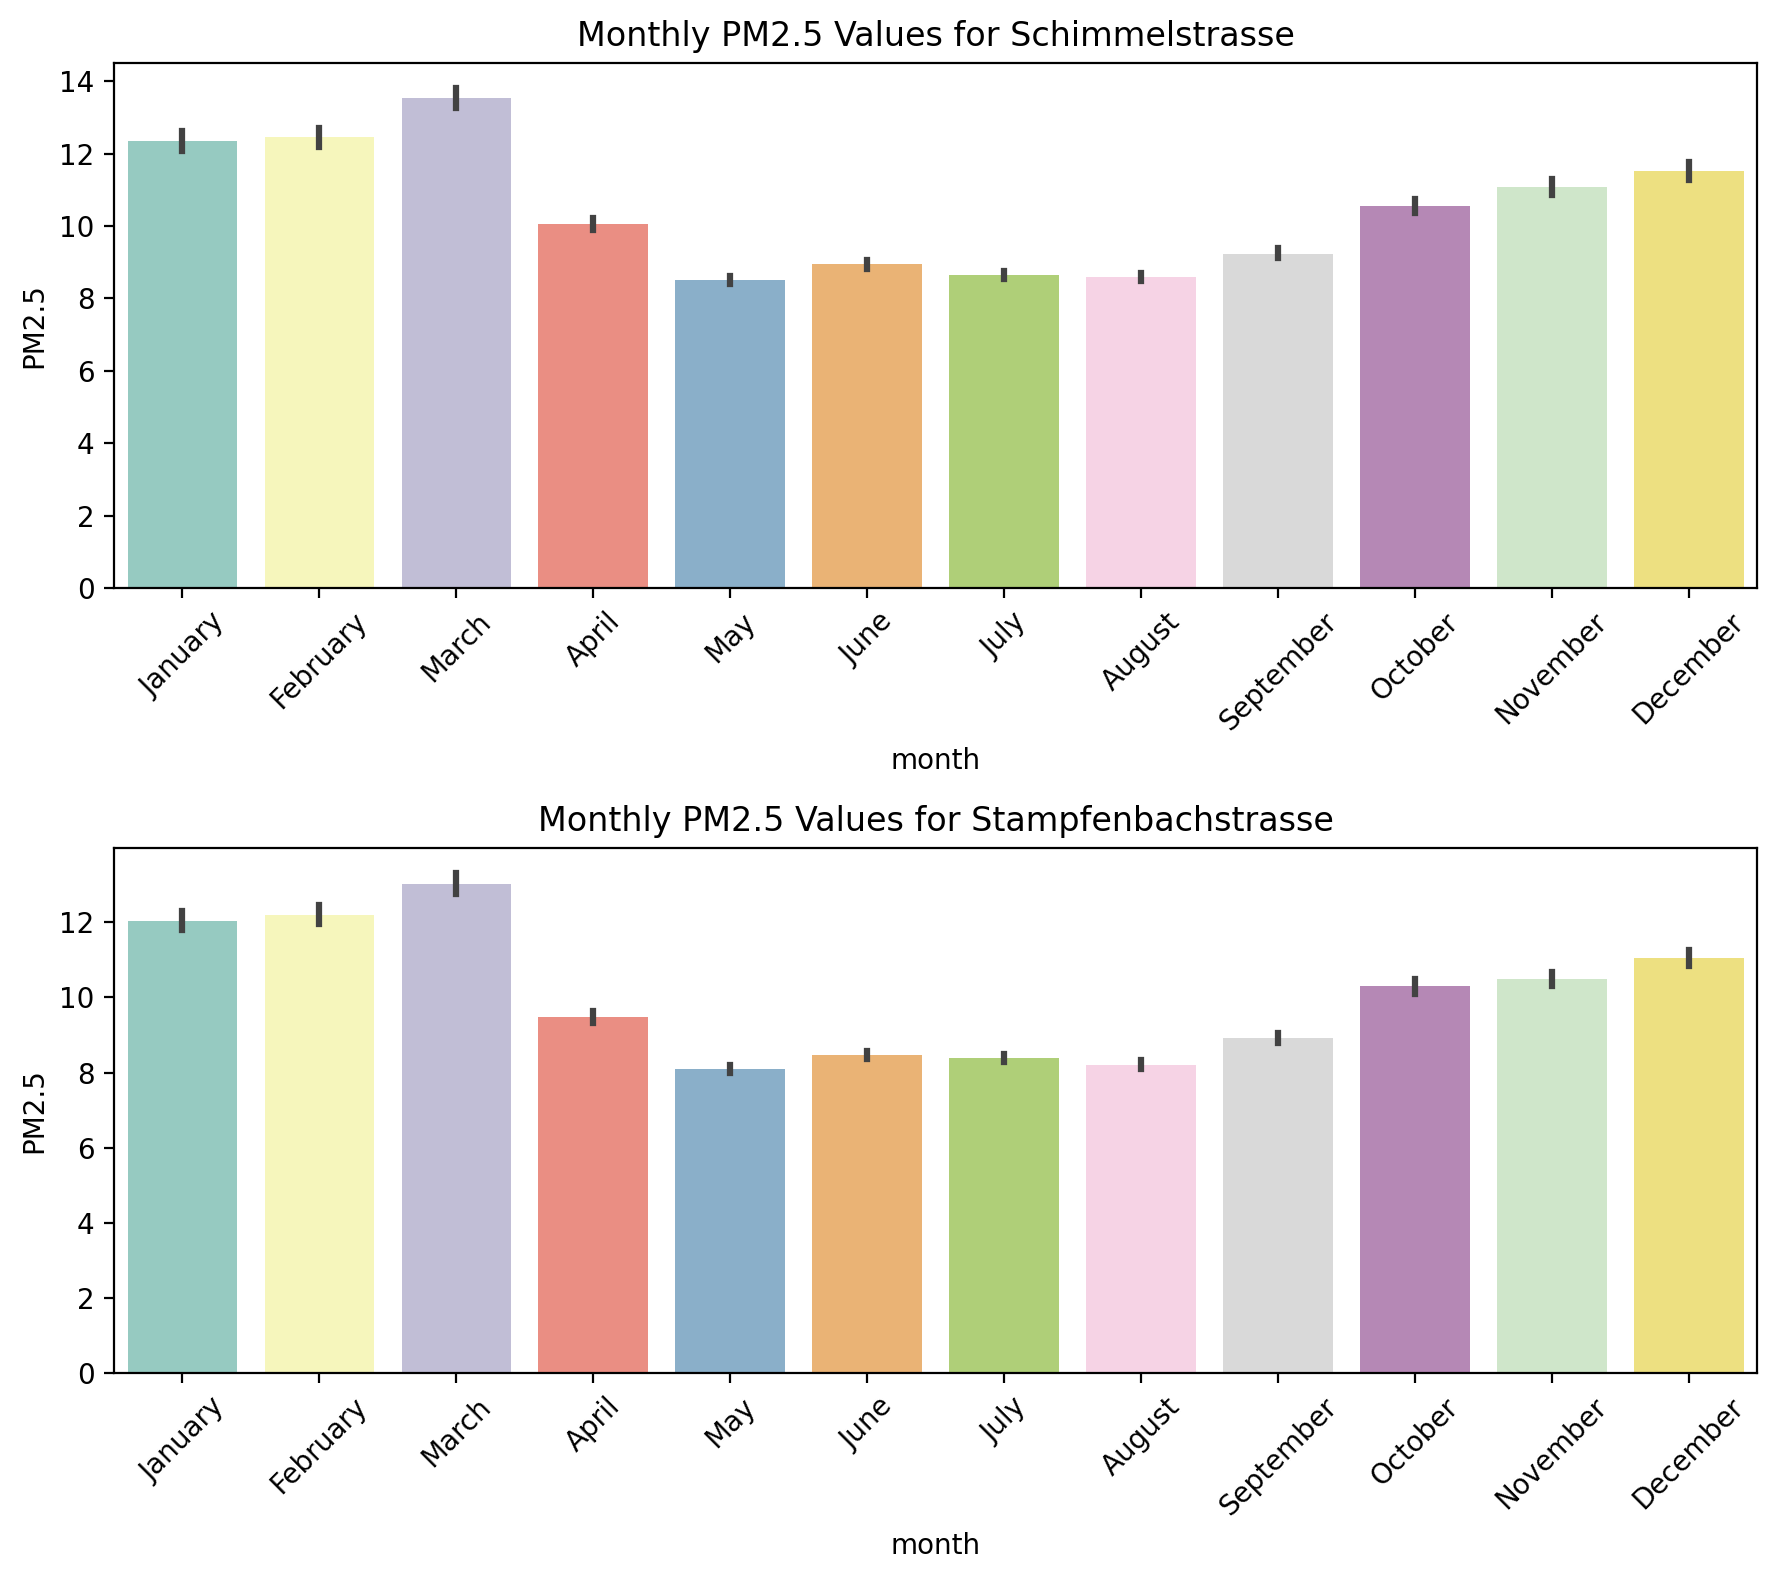

In [373]:
n_location = transformed_df.location.nunique()

fig, axes = plt.subplots(nrows=n_location, ncols=1, figsize=(9, 8))

for idx, location in enumerate(transformed_df['location'].unique()):
    df_filtered = transformed_df[transformed_df['location'] == location]
    
    sns.barplot(x='month', y='PM2.5', data=df_filtered ,hue='month', palette='Set3', ax=axes[idx])


    axes[idx].set_title(f'Monthly PM2.5 Values for {location}')
    axes[idx].set_ylabel('PM2.5')
    axes[idx].tick_params(axis='x', rotation=45)

    
plt.tight_layout()
plt.show()

#### Intepretation
[Why do pollution levles skyrocket during winter?](https://weather.com/en-IN/india/science/news/2018-10-30-why-do-pollution-levels-skyrocket-during-winter )

What can be immediately observed is that the air quality values, in this case the PM2.5 level, are higher in the colder seasons than in the warmer ones. This is due to the phenomenon of [winter inversion](https://www.wetteronline.de/wetterlexikon/inversion), where colder air is trapped near the ground, preventing the exchange between the upper and lower layers of the atmosphere. This leads to an accumulation of pollutants in the lower atmosphere. A historical example of the severe impacts of such an inversion is the ["Great London Smog of 1952 "](https://de.wikipedia.org/wiki/Smog-Katastrophe_in_London_1952), which claimed over 10,000 lives. These observations confirm the significance of inversion weather conditions for air quality, especially in urban areas.

### Visualisation by Day 

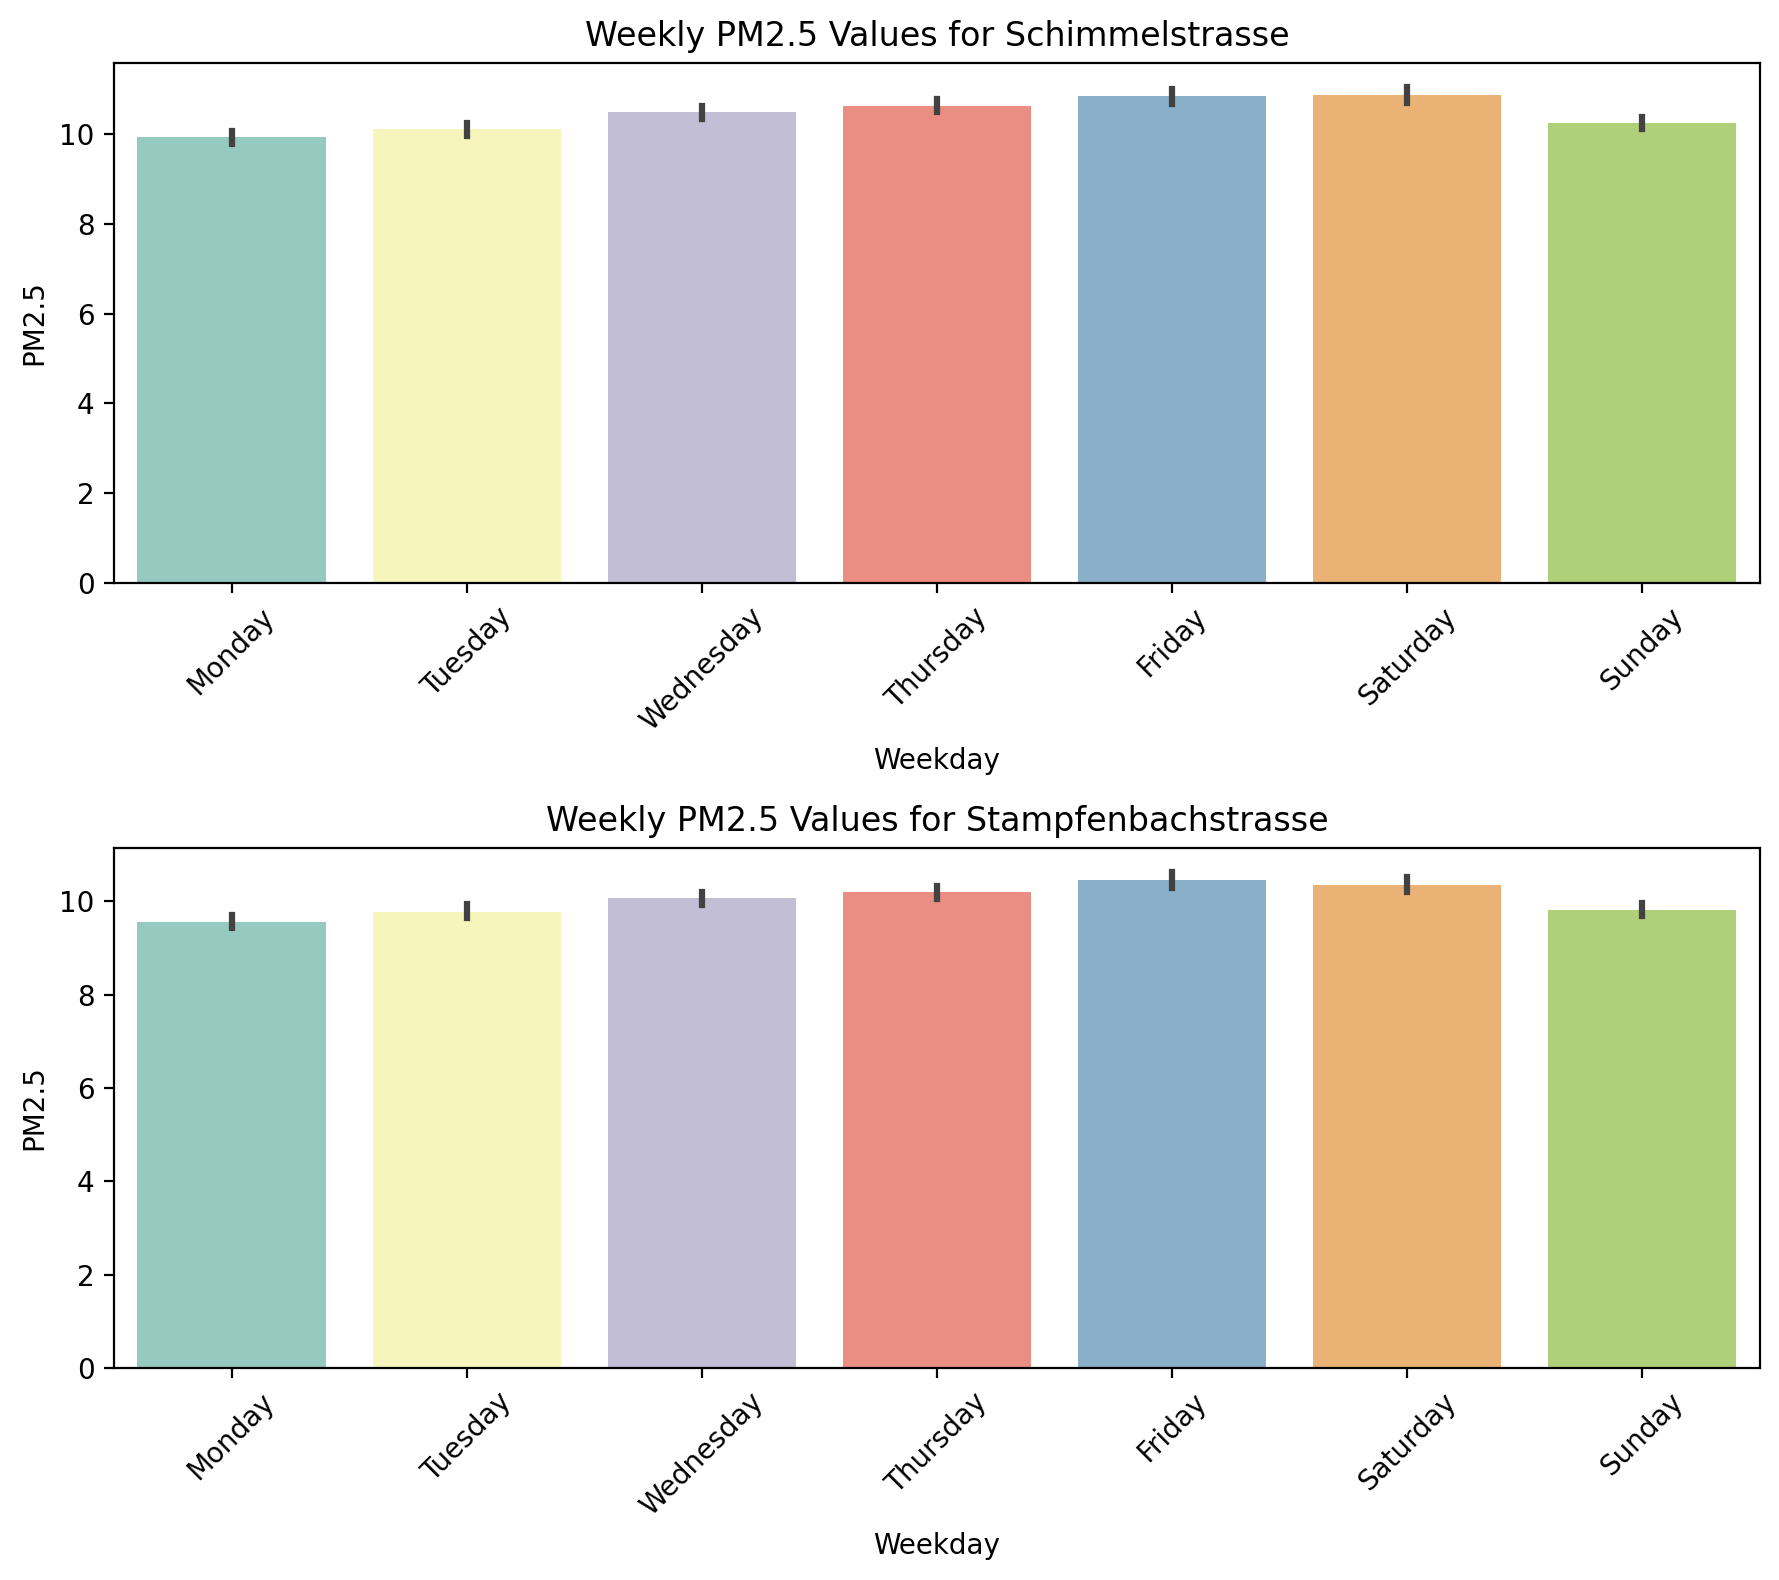

In [374]:
n_location = transformed_df.location.nunique()

fig, axes = plt.subplots(nrows=n_location, ncols=1, figsize=(9, 8))

for idx, location in enumerate(transformed_df['location'].unique()):
    df_filtered = transformed_df[transformed_df['location'] == location]
    
    sns.barplot(x='weekday', y='PM2.5', data=df_filtered, hue='weekday', palette='Set3', ax=axes[idx])


    axes[idx].set_title(f'Weekly PM2.5 Values for {location}')
    axes[idx].set_xlabel('Weekday')
    axes[idx].set_ylabel('PM2.5')
    axes[idx].tick_params(axis='x', rotation=45)
    
plt.tight_layout()
plt.show()

#### Interpretation
The analysis of data from the Stampfenbachstrasse and Rosengartenstrasse weather stations reveals that both exhibit similar patterns in PM2.5 levels. The steady increase in PM2.5 concentrations throughout the week, peaking on Friday, suggests a direct correlation with weekly traffic volumes. It is particularly interesting to note that the values do not decrease over the weekend as expected but instead reach their peak starting from Friday. This could indicate changes in traffic or activity patterns during the weekend, such as a reduction in commuter traffic or a shift to other sources of emissions. It might also mean that factors other than traffic, such as weather conditions, have a more significant impact on PM2.5 levels. These findings highlight the complexity of factors influencing air quality and the necessity of considering various variables to obtain a complete picture of air quality dynamics.

### Visualisation by Hour 

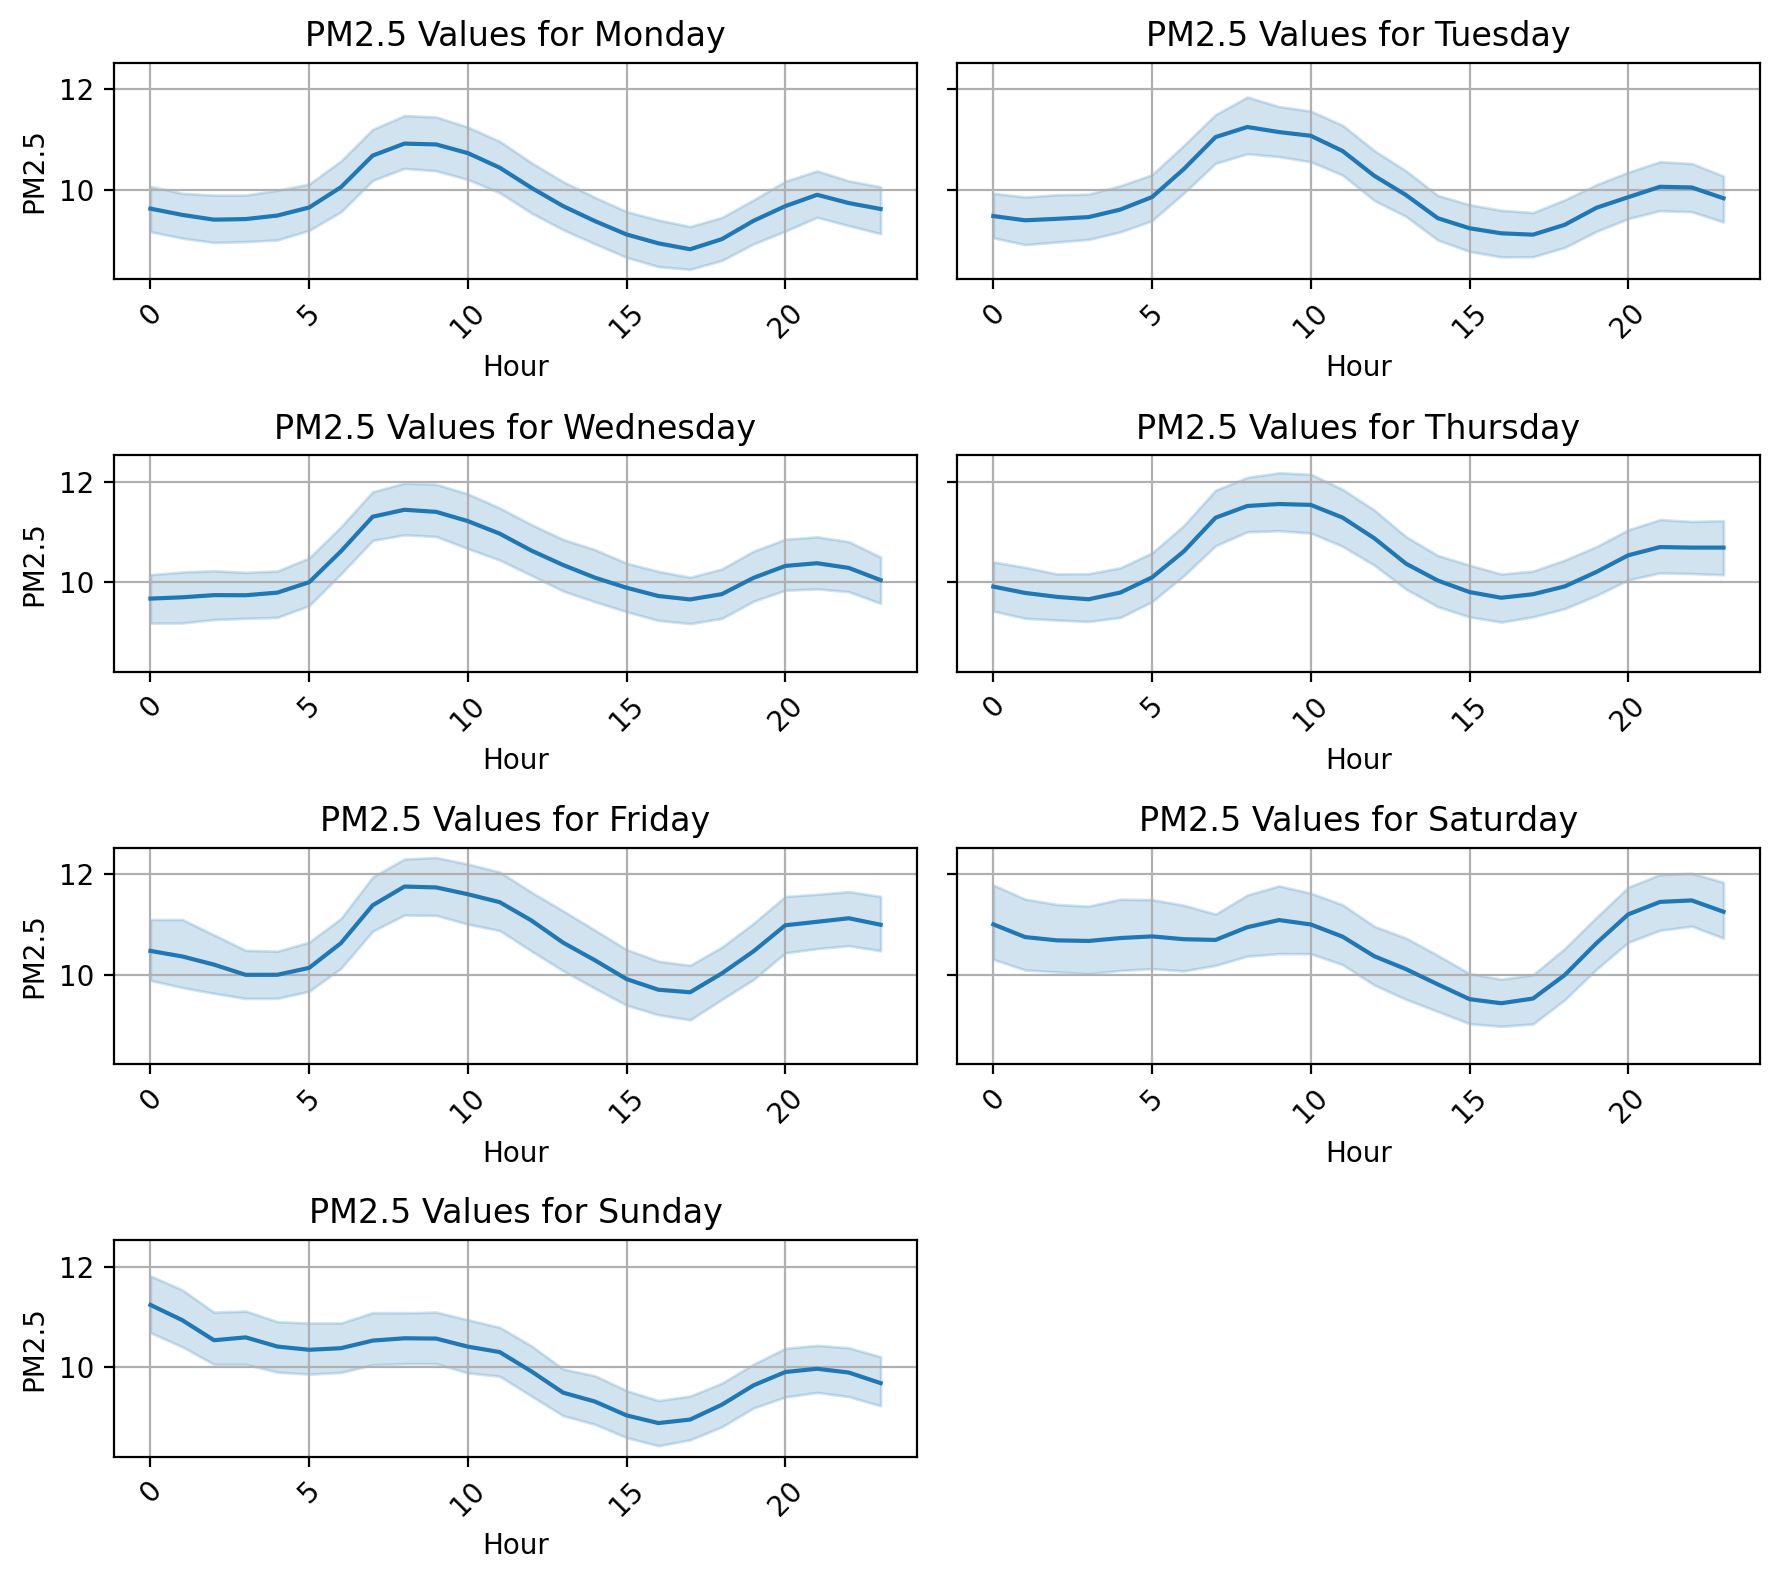

In [375]:
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(9, 8), sharey=True)

for idx, weekday in enumerate(weekdays):
    row_idx = idx // 2
    col_idx = idx % 2

    if weekday in transformed_df['weekday'].values:
        df_filtered = transformed_df[transformed_df['weekday'] == weekday]
        sns.lineplot(x='hour', y='PM2.5', data=df_filtered, ax=axes[row_idx, col_idx])

        axes[row_idx, col_idx].set_title(f'PM2.5 Values for {weekday}')
        axes[row_idx, col_idx].set_xlabel('Hour')
        axes[row_idx, col_idx].set_ylabel('PM2.5')
        axes[row_idx, col_idx].tick_params(axis='x', rotation=45)
        axes[row_idx, col_idx].grid()

# Hide the empty subplots
fig.delaxes(axes[3,1])


plt.tight_layout()
plt.show()


#### Interpretation


From Monday to Friday, the PM2.5 levels peak sharply at 8 AM, likely due to morning traffic, then decrease significantly, with a smaller rise around 4 PM indicating evening rush hour. On Saturdays, there's an unusual increase in PM2.5 during the night, followed by a steady decrease, reaching the lowest levels around 4 PM, and then slightly increasing again. Sundays show a consistent decline in PM2.5 throughout the day, bottoming out around 4 PM, with a slight uptick in the evening.

### Correlation

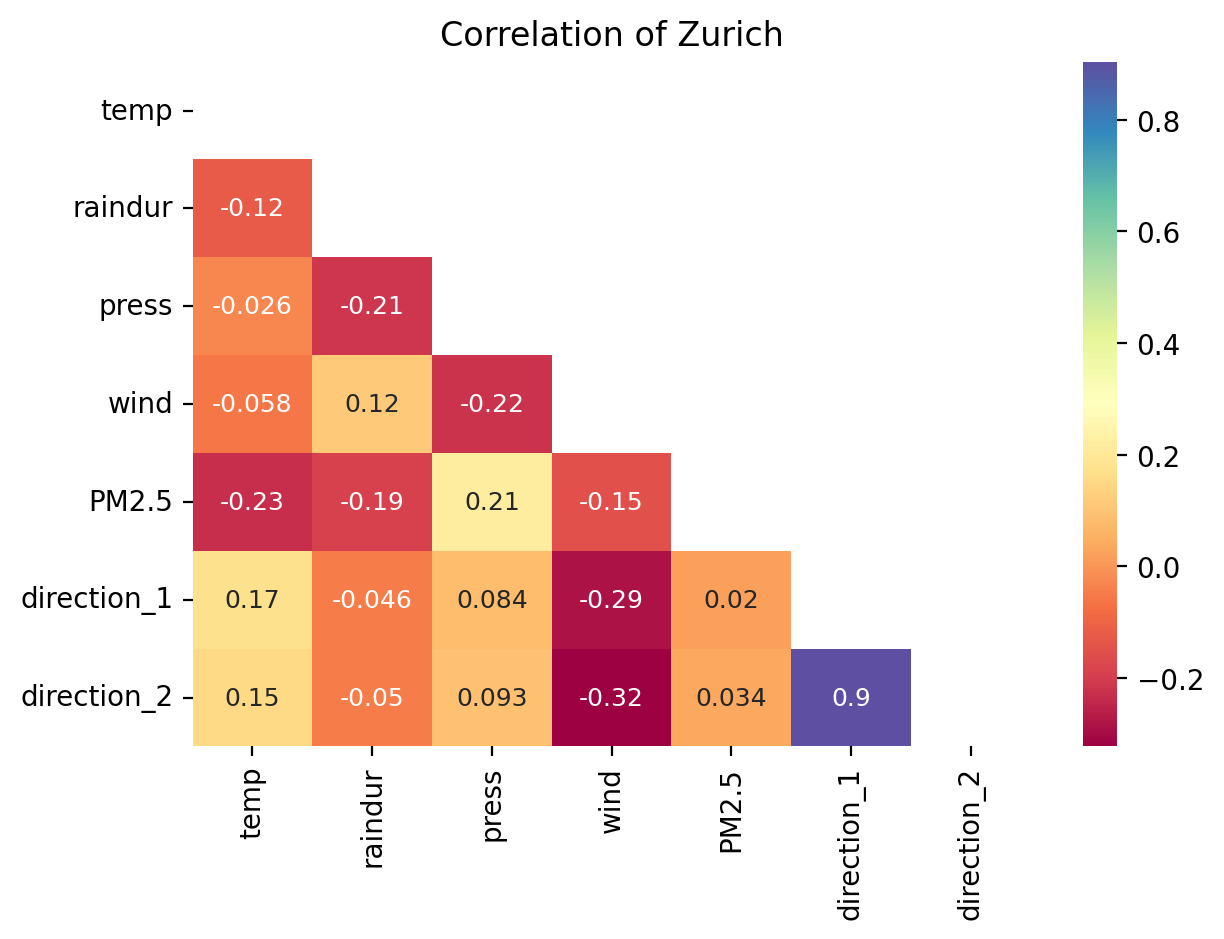

In [376]:
zuerich_correlation = transformed_df.drop(['location', 'hour', 'weekday', 'month', 'day', 'year'], axis=1)

corr_matrix = zuerich_correlation.corr()

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

sns.heatmap(corr_matrix, mask=mask, annot=True, annot_kws={"size": 9},cmap='Spectral').set_title('Correlation of Zurich')

plt.tight_layout()
plt.show()


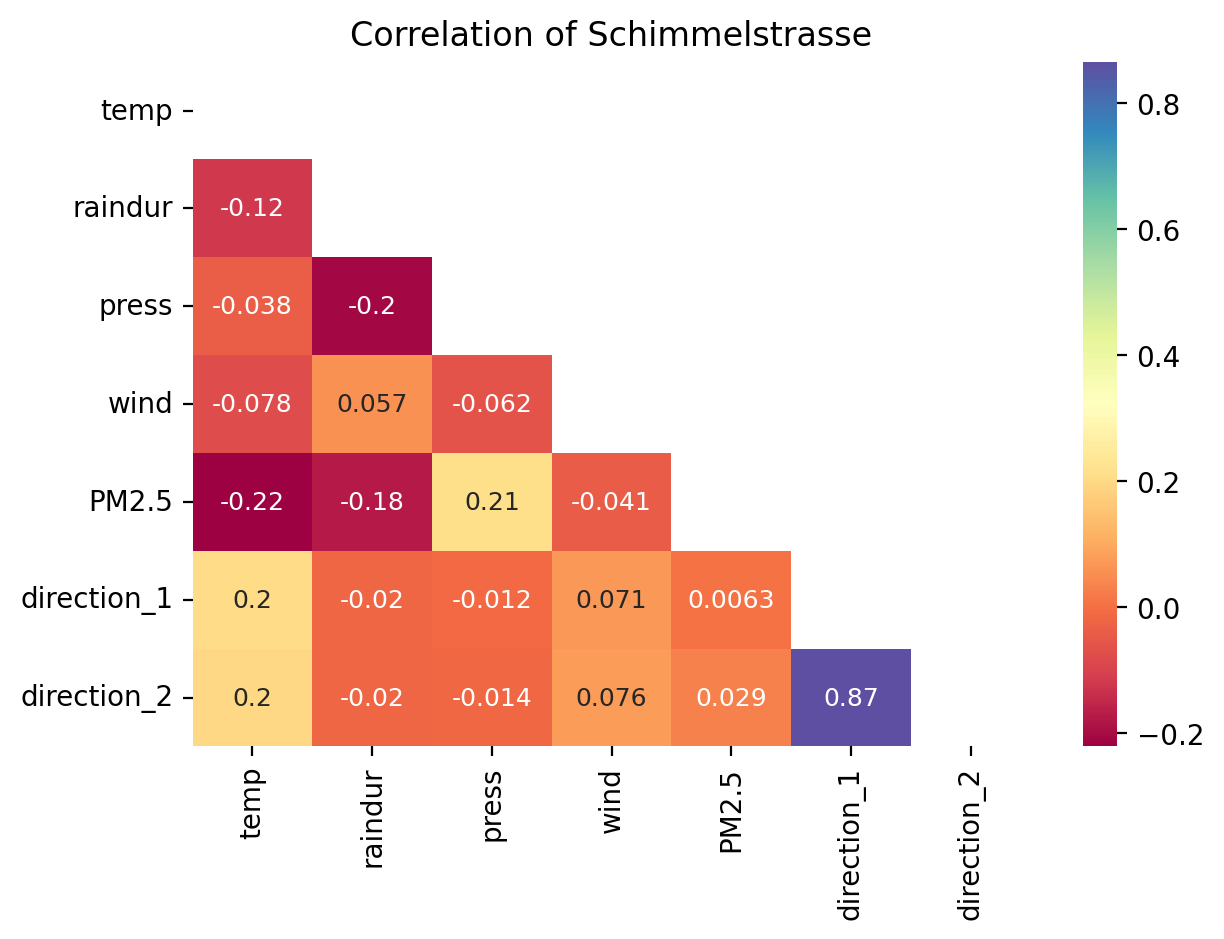

In [377]:
filtered_schimmel  = transformed_df[transformed_df['location'] == 'Schimmelstrasse']

schimmel_strasse = filtered_schimmel.drop(['location', 'weekday', 'month', 'day', 'year', 'hour'], axis=1)

corr_matrix = schimmel_strasse.corr()

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

sns.heatmap(corr_matrix, mask=mask, annot=True, annot_kws={"size": 9},cmap='Spectral').set_title('Correlation of Schimmelstrasse')

plt.tight_layout()
plt.show()


<Figure size 1200x1200 with 0 Axes>

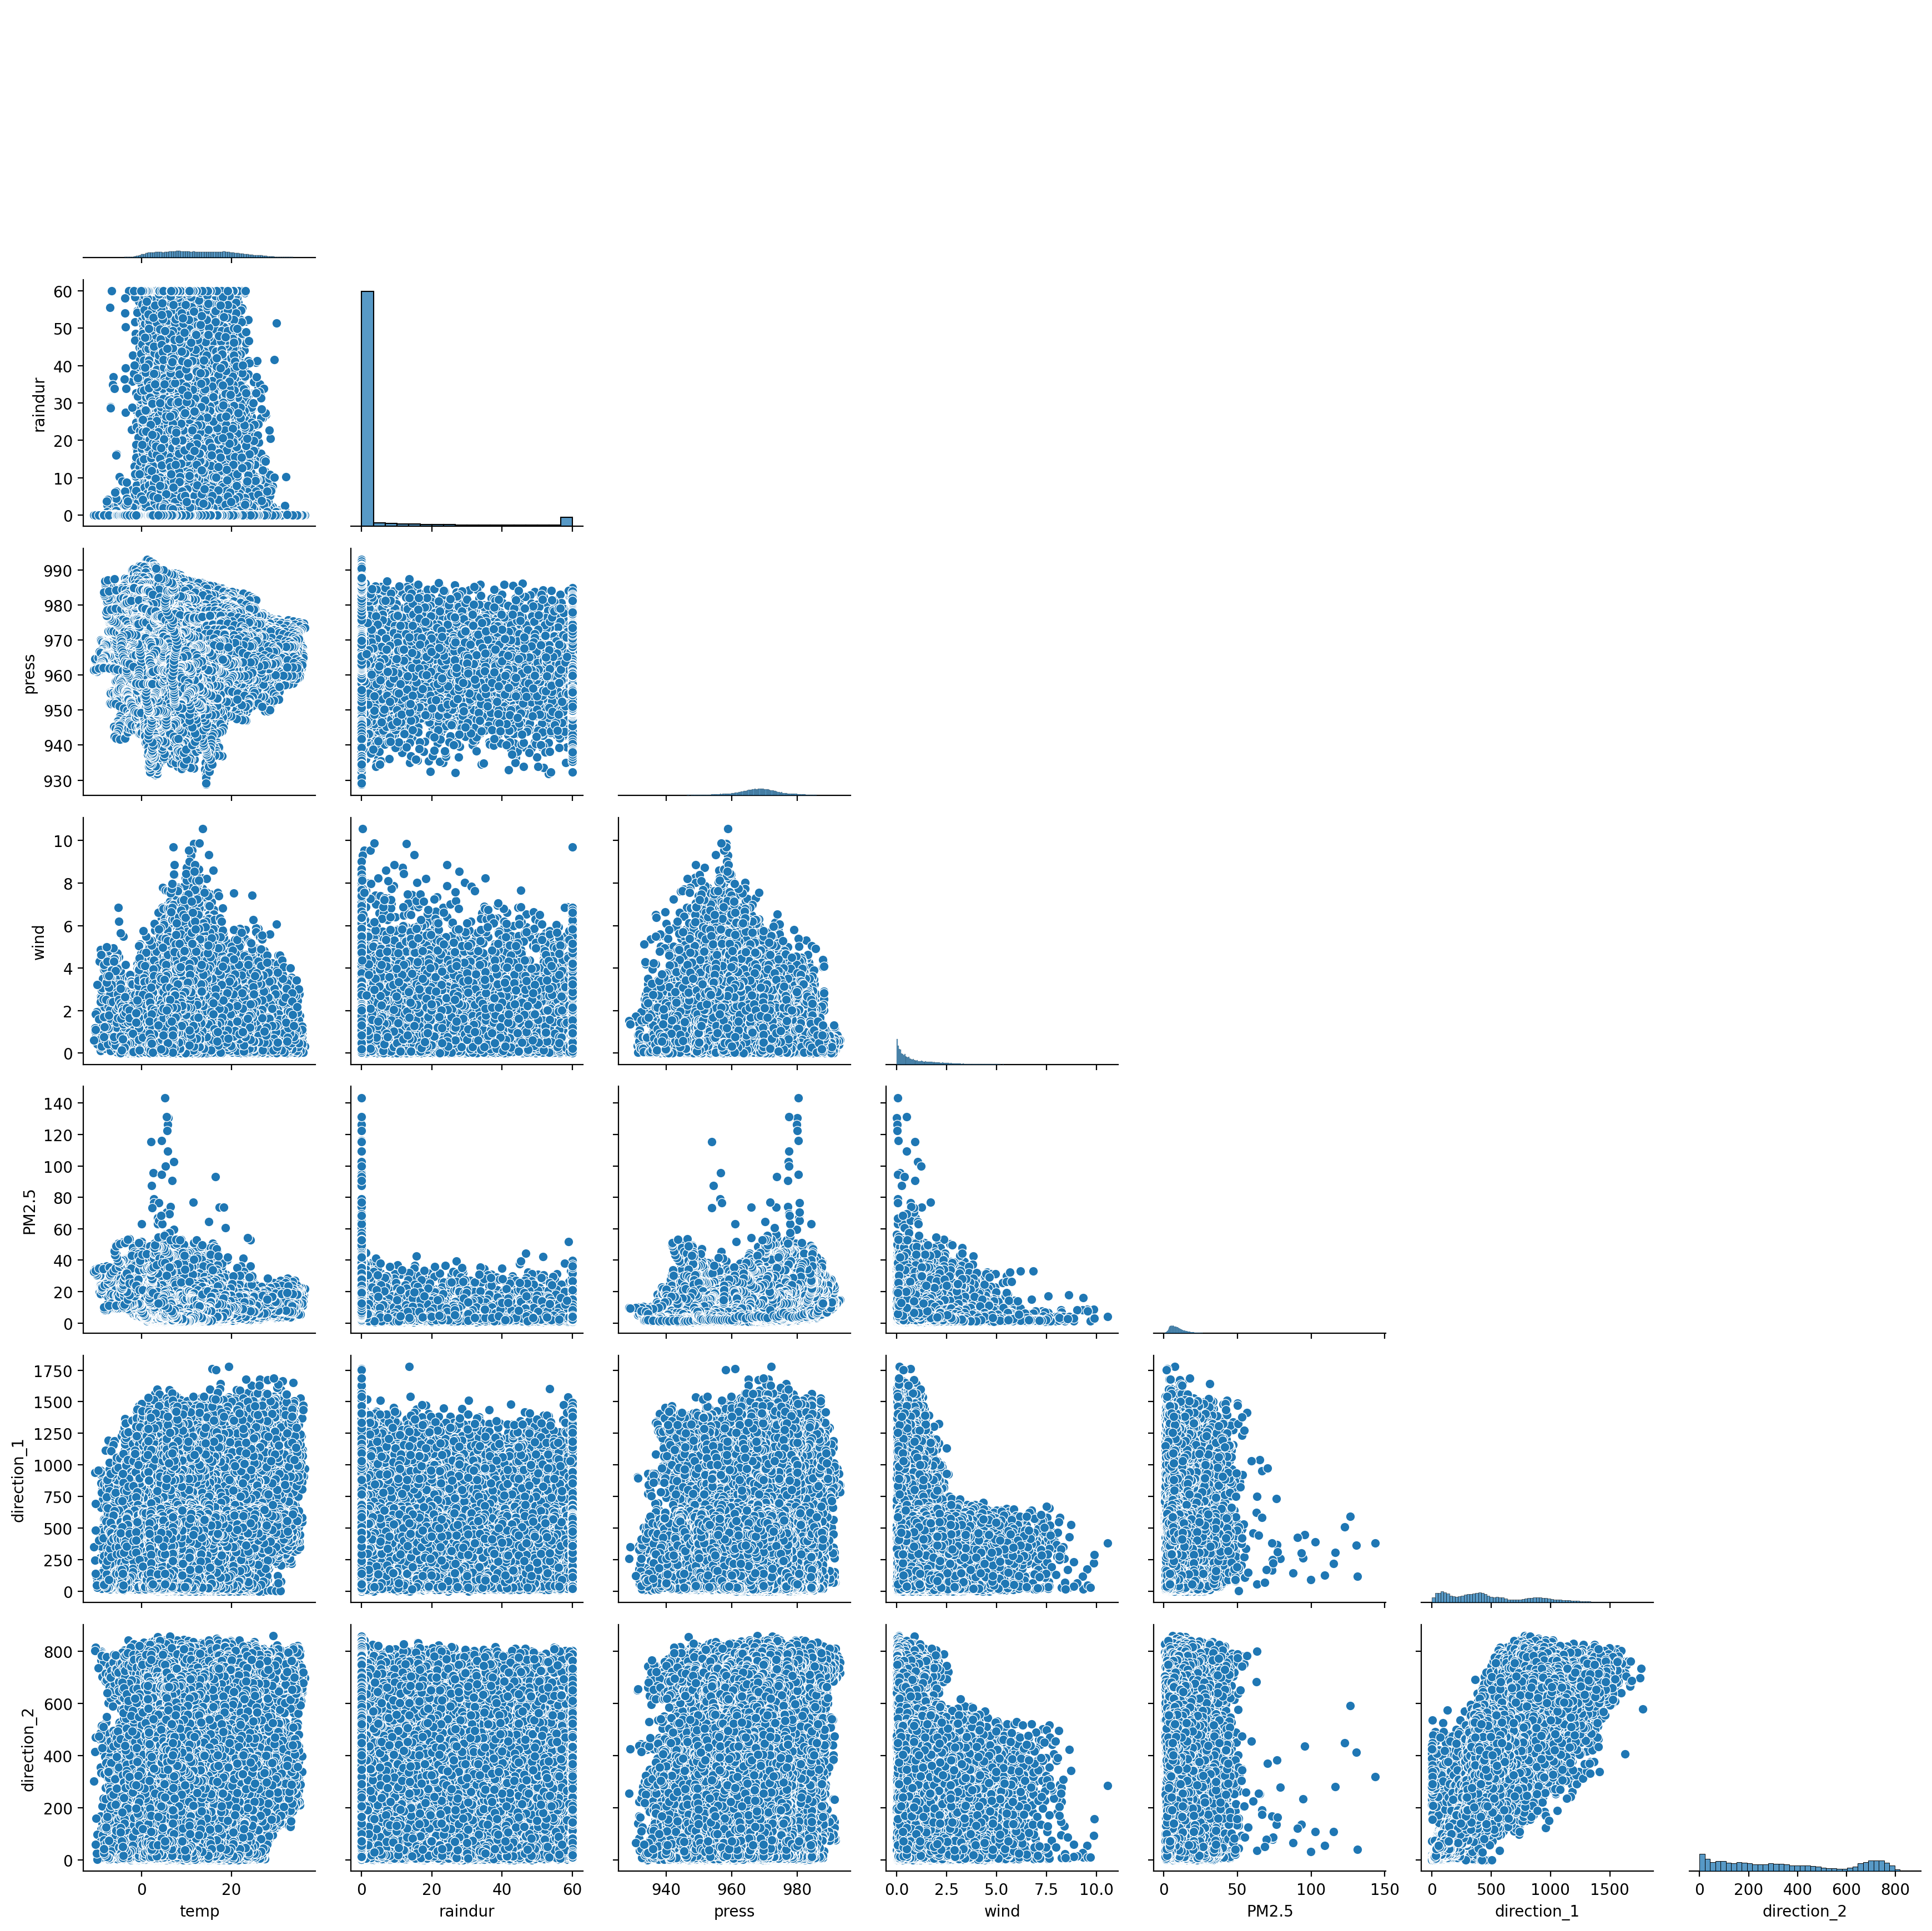

In [378]:
subset_dataframe = transformed_df.drop(['location', 
                                        'weekday', 
                                        'month', 
                                        'day', 
                                        'year',
                                        'hour'], axis=1)

plt.figure(figsize=(6, 6))
sns.pairplot(subset_dataframe, corner = True)
plt.tight_layout()
plt.show()

#### Intepretation
As we can be clearly see, there are no distinct correlations between the PM2.5 value and the other parameters. This does not seem favorable for our model, that is why we are interested in the model's results.

## Data Preparation

### One-Hot Encoding 

In [379]:
def one_hot_encode(ml_dataframe, categorical):

    """
    One-hot encodes specified categorical columns in a DataFrame.

    Parameters:
    - ml_dataframe (pd.DataFrame): The input DataFrame.
    - categorical_columns (list): List of column names to be one-hot encoded.

    Returns:
    - pd.DataFrame: The DataFrame with one-hot encoded columns.
    """

    # Initialize One-Hot Encoder
    encoder = OneHotEncoder()

    # Fit and Transform the Categorial Data
    encoded_data = encoder.fit_transform(ml_dataframe[categorical])

    #Create a DataFrame from Encoded Data
    encoded_df = pd.DataFrame(encoded_data.toarray(), columns=encoder.get_feature_names_out(categorical))

    # Concatenate Original DataFrame with Encoded DataFrame
    ml_dataframe = pd.concat([ml_dataframe.reset_index(drop=True), encoded_df], axis=1)

    # Drop Original Categorical Columns
    ml_dataframe = ml_dataframe.drop(categorical, axis=1)

    return ml_dataframe


In [380]:
# Onehot encoding of the specified paramters:

categorical_columns =  ['weekday', 'month', 'year', 'location']

ml_dataframe = one_hot_encode(transformed_df, categorical_columns)

#### The Dataframe:

In [381]:
ml_dataframe.head(5)

temp  raindur   press  wind  PM2.5  direction_1  direction_2  hour  day  \
0  9.60     0.00  962.07  0.70  13.75        341.0        339.0     0    1   
1  9.53     0.00  962.47  0.99   9.71        538.0        705.0     1    1   
2  8.65    25.05  963.84  0.43   8.94        444.0        398.0     2    1   
3  7.42    56.22  965.28  1.93   4.66        344.0        281.0     3    1   
4  6.65    11.75  965.88  0.44   4.19        255.0        217.0     4    1   

   weekday_Friday  ...  month_October  month_September  year_2018  year_2019  \
0             0.0  ...            0.0              0.0        1.0        0.0   
1             0.0  ...            0.0              0.0        1.0        0.0   
2             0.0  ...            0.0              0.0        1.0        0.0   
3             0.0  ...            0.0              0.0        1.0        0.0   
4             0.0  ...            0.0              0.0        1.0        0.0   

   year_2020  year_2021  year_2022  year_2023  location_Schimmelstrasse  \
0        0.0        0.0        0.0        0.0                       1.0   
1        0.0        0.0        0.0        0.0                       1.0   
2        0.0        0.0        0.0        0.0                       1.0   
3        0.0        0.0        0.0        0.0                       1.0   
4        0.0        0.0        0.0        0.0                       1.0   

   location_Stampfenbachstrasse  
0                           0.0  
1                           0.0  
2                           0.0  
3                           0.0  
4                           0.0  

[5 rows x 36 columns]

## Test different Models


In [382]:
# Drop the PM2.5 column
X = ml_dataframe.drop(['PM2.5'] , axis=1)
y = ml_dataframe['PM2.5']

We decided to train multiple models to determine which one performs best, allowing us to choose the most effective model for further testing and optimal results. Furthermore, we decided to use cross-validation, splitting the DataFrame into five parts, to ensure a more robust and unbiased evaluation of each model. This approach allows each model to be trained and tested on different subsets of the data, providing a comprehensive understanding of their performance and generalizability.

In [383]:
def test_models(models, names,X, y, n=5):

    """
    Evaluate machine learning models using cross-validation.

    Parameters:
    - models (list): List of machine learning models to be tested.
    - names (list): List of names corresponding to the models.
    - X (array-like): Feature matrix.
    - y (array-like): Target variable.
    - n (int): Number of cross-validation folds.

    Returns:
    - pd.DataFrame: DataFrame containing the results of the cross-validation for each model.
    """

    test_results = [cross_validate(model, X, y, cv=n) for model in models]

    results = []

    for i, _ in enumerate(test_results):

        result = pd.DataFrame({ 'model': [names[i]],
                                'fit_time': [np.mean(test_results[i]['fit_time'])], 
                                'score_time': [np.mean(test_results[i]['score_time'])],
                                'test_score' : [np.mean(test_results[i]['test_score'])]
        })
        results.append(result)

    return pd.concat(results, ignore_index=True)

In [384]:
# Defining the models:

model_ln = LinearRegression()
model_ridge = Ridge()
model_lasso = Lasso()
model_xg = XGBRegressor()
model_kn = KNeighborsRegressor()
model_tree = DecisionTreeRegressor()

models = [model_ln, model_ridge, model_lasso, model_xg, model_kn, model_tree]
model_names = ['Linear Regression', ' Ridge Regression', 'Lasso Regression', 'XGB Regressor', 'KNeighbors Regressor', 'Decision Tree Regressor']


# Testing the models:
test_models(models, model_names, X, y)

model  fit_time  score_time  test_score
0        Linear Regression  0.107537    0.010427    0.152883
1         Ridge Regression  0.056054    0.006095    0.152890
2         Lasso Regression  0.234147    0.005420    0.103395
3            XGB Regressor  0.613102    0.024101    0.638077
4     KNeighbors Regressor  0.044410    2.965878   -0.069451
5  Decision Tree Regressor  2.642862    0.009723    0.275402

As you can see, the XGB Regressor had a test score of 64.14% and has performed way better than the other models. The reason is its advanced ability to handle a variety of data types and its effective use of gradient boosting techniques. XGB Regressor's sophisticated algorithm optimizes weak learning models sequentially, minimizing errors step by step, and thus, it tends to produce more accurate and reliable predictions compared to simpler models. This makes it particularly suitable for complex datasets where relationships between variables are not easily discernable

In [385]:
def plot_learning_curve(model, X, y, cv=3, n_jobs=-1):
    
    """
    Plot the learning curve of a machine learning model.

    Parameters:
    - model: The machine learning model for which the learning curve is plotted.
    - X: Feature matrix.
    - y: Target variable.
    - cv: Number of cross-validation folds.
    - n_jobs: Number of CPU cores to use for parallelization.

    Returns:
    - None: The function plots the learning curve using Matplotlib.
    """

    train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=cv, n_jobs=n_jobs)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)

    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    y_min = np.min(test_scores_mean - test_scores_std)

    plt.plot(train_sizes, train_scores_mean, 'bo-', label='Training score')
    plt.plot(train_sizes, test_scores_mean, 'go-', label=f'Testing score (cv={cv})')
    plt.fill_between(train_sizes, 
                     train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std,
                     alpha=0.1,
                     color="b")
    plt.fill_between(train_sizes,
                     test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std,
                     alpha=0.1,
                     color="g")
    plt.ylim((y_min,1))
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.title("Learning curve")
    plt.legend(loc="best")
    plt.grid()

    print("training scores:",train_scores_mean)

training scores: [0.98218613 0.92782994 0.87850037 0.85467124 0.84178989]


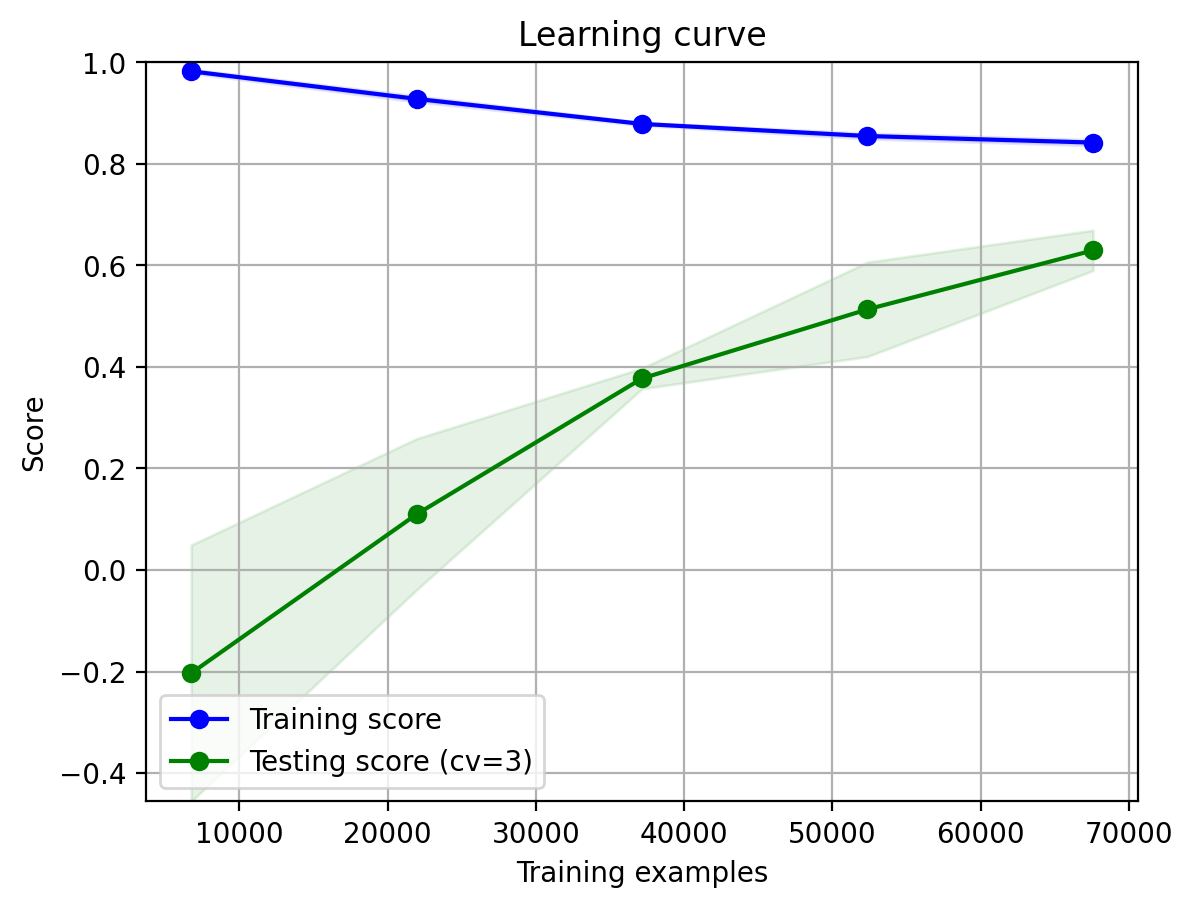

In [386]:
# Plot the learning curve:

plot_learning_curve(model_xg, X, y)

#### Intepreation of the learning curve

**Training Score:** The training score remains consistently high as the number of training examples increases.This indicates that the model has a good fit on the training data throughout the training process.

**Testing Score:** The testing score line starts at a low score with few training examples but improves significantly as more data is introduced.

**Performance Plateau:** Both scores seem to flat out, with the training score leveling off near a value of 1 and the testing score stabilizing around 0.6. It suggests that the model has learned as much as it can from the data, and additional training examples may not lead to significant improvements.

In summary, the model seems to be performing well on the training data but is not quite as well to unseen data, as indicated by the lower cross-validation scores. To improve the model's performance, we considered tuning the hyperparameters.

## Hyperparameter tuning

In [387]:
if RUN_MODEL_OPTIMIZATION:

    # Fix compatibilty issues of BayesSearch and newer numpy versions:
    np.int = int

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


    param_space = {


        'learning_rate': (0.01, 1.0, 'log-uniform'),
        'n_estimators': (50,200),
        'max_depth': (3, 10),
        'subsample': (0.1, 1.0, 'uniform'),
        'colsample_bytree': (0.1, 1.0, 'uniform'),
    }

    xgb_reg = XGBRegressor()
    bayes_cv = BayesSearchCV(xgb_reg, param_space, n_iter=50, cv=5, n_jobs=-1)
    bayes_cv.fit(X_train, y_train)

    print("Best Parameters:", bayes_cv.best_params_)

    xgb_reg = XGBRegressor( 
                        colsample_bytree = bayes_cv.best_params_['colsample_bytree'],
                        learning_rate = bayes_cv.best_params_['learning_rate'],
                        max_depth = bayes_cv.best_params_['max_depth'],
                        n_estimators= bayes_cv.best_params_['n_estimators'],
                        subsample = bayes_cv.best_params_['subsample'],
                    )

    print('Model with new optimized paramters created')

    # Create the names
    repository = 'model'
    file = f'xgb_regressor_model_{dt.date.today()}.joblib'

    # Ensure the repository exists
    os.makedirs(repository, exist_ok=True)

    # Specify the filename (with the .joblib extension)
    filename = os.path.join(repository, file)

    dump(xgb_reg, filename) 

    print('Model saved')

else:

    xgb_reg = XGBRegressor( colsample_bytree = 0.9430740874440615,
                            learning_rate = 0.2940673946336409,
                            max_depth = 10,
                            n_estimators = 200,
                            subsample = 0.9999999882582344)

    repository = 'model'
    file = f'xgb_regressor_model_best_test.joblib'

    # Ensure the repository exists
    os.makedirs(repository, exist_ok=True)

    # Specify the filename (with the .joblib extension)
    filename = os.path.join(repository, file)

    dump(xgb_reg, filename) 

    best_params = xgb_reg.get_params()

    print(f"Model Parameters:{dict(zip(['colsample_bytree','learning_rate', 'max_depth', ' n_estimators', 'subsample'],[0.9430740874440615, 0.2940673946336409,  10, 200, 0.9999999882582344]))}")


Best Parameters: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.18445689985722064), ('max_depth', 10), ('n_estimators', 200), ('subsample', 0.8657810513851754)])
Model with new optimized paramters created
Model saved


1. **Learning Rate (`learning_rate`):**
   - Chosen values: [0.01, 0.1, 0.5, 1]
   - The learning rate controls the contribution of each tree to the final prediction. Smaller values usually lead to better generalization but require more trees. We chose a range of values to explore the impact of different learning rates.

2. **Number of Estimators (`n_estimators`):**
   - Chosen values: [50, 100, 150, 200]
   - The number of estimators represents the number of boosting rounds (trees) in the ensemble. It's important to find a balance between having enough trees to capture the patterns in the data and avoiding overfitting. The range covers a reasonable number of trees for experimentation.

3. **Maximum Depth of a Tree (`max_depth`):**
   - Chosen values: [3, 5, 7, 10]
   - The maximum depth of a tree controls the complexity of the individual trees. Deeper trees can capture more complex relationships in the data but may lead to overfitting. The selected values cover a range from shallow to moderately deep trees.

4. **Subsample (`subsample`):**
   - Chosen values: [0.1, 0.5, 0.9, 1.0]
   - Subsample represents the fraction of samples used for fitting the individual trees. A lower value can add randomness and prevent overfitting. We explore a range of values to observe the impact on the model's performance.

5. **Colsample by Tree (`colsample_bytree`):**
   - Chosen values: [0.1, 0.5, 0.9, 1.0]
   - Colsample bytree controls the fraction of features (columns) used for building each tree. It adds diversity to the ensemble, helping prevent overfitting. The selected values cover a range of feature subsampling.

These parameters are commonly tuned in practice to find the best combination for a given dataset. The specific values and ranges might need adjustment based on the characteristics of your data. The goal is to find a set of hyperparameters that provides the best balance between model complexity and generalization performance.


## Train and Evaluate the Model:

In [388]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

if not RUN_MODEL_OPTIMIZATION:
    xgb_reg = load('model/xgb_regressor_model_best_test.joblib')


xgb_reg.fit(X_train, y_train)

y_pred = xgb_reg.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"r2: {r2}")


Mean Squared Error: 3.7510592210624285
Root Mean Squared Error: 1.9367651434963478
r2: 0.912451863260748


## Results 

Our air pollution prediction model for Zurich, utilizing the XGBoost Regressor, exhibits a strong performance with an R-squared value of around 0.91. This suggests a notable capability to explain the variability in air pollution based on selected factors. The complexity of the XGBoost model allows it to discern intricate patterns in the data. Although direct correlations might not be readily apparent, the model's predictive accuracy underscores its efficacy in understanding air pollution dynamics in Zurich.


## Test the Model with live data - a little experiment:


In [389]:
def get_live_weather_data(): 
    # API key for OpenWeatherMap
    api_key = 'b5510389d8598f5dfa28ed24705d783f'
    # City for which live weather data is requested
    city = 'Zürich'

    # API request to OpenWeatherMap
    url = f'https://api.openweathermap.org/data/2.5/weather?q={city}&APPID={api_key}&units=metric'
    weather_data = requests.get(url).json()

    # Display live weather information
    print(
        f'''
        Live Weather in {city} ({weather_data['sys']['country']}):
        - Temperature:              {weather_data['main']['temp']} °C
        - Weather:                  {weather_data['weather'][0]['main']}
        - Barometric pressure:      {weather_data['main']['pressure']} hPa
        - Windspeed:                {weather_data['wind']['speed']} m/s
        '''
    )

    # Get the current date and time
    current_datetime = dt.datetime.now()

    # Create a DataFrame to store live weather data
    live = pd.DataFrame()
    live['temp'] = [weather_data['main']['temp']]
    # Check if it's raining
    live['rain'] = rain = 1 if weather_data['weather'][0]['main'] == 'Rain' else 0
    live['press'] = [weather_data['main']['pressure']]
    live['wind'] = [weather_data['wind']['speed']]
    live['date'] = pd.to_datetime([current_datetime.strftime("%Y-%m-%d %H:%M:%S")])

    return live


In [390]:
# Take the weather and pollution data without traffic or location:
ml_test = transform_dates(weather_Pollution_df)
ml_test = ml_test.drop('location', axis=1)
ml_test = ml_test.dropna()
ml_dataframe = ml_test

# Create a rain feature, because there is no rain duration info in live data:
ml_dataframe['rain'] = ml_dataframe['raindur'].apply(lambda x: 1 if x > 0 else 0)
ml_dataframe = ml_dataframe.drop('raindur', axis=1)

# get the live data:
live_data = get_live_weather_data()

# concat the live data with the dataset to onehot encode all the months of the year:
categorical_columns =  ['weekday', 'month', 'year']

live_data = transform_dates(live_data)
X_new = pd.concat([ml_dataframe, live_data])
X_new = one_hot_encode(X_new, categorical_columns)

# Extract the live data:
live_values = X_new.iloc[[-1]]
training_df = X_new.drop(X_new.index[-1])


# Drop the PM2.5 values
live_values = live_values.drop('PM2.5', axis=1)
X = training_df.drop('PM2.5', axis=1)
y = training_df['PM2.5']


live_values


        Live Weather in Zürich (CH):
        - Temperature:              1.34 °C
        - Weather:                  Clouds
        - Barometric pressure:      1039 hPa
        - Windspeed:                1.03 m/s
        


temp   press  wind  hour  day  rain  weekday_Friday  weekday_Monday  \
102125  1.34  1039.0  1.03    17   17     0             0.0             0.0   

        weekday_Saturday  weekday_Sunday  ...  month_May  month_November  \
102125               0.0             1.0  ...        0.0             0.0   

        month_October  month_September  year_2018  year_2019  year_2020  \
102125            0.0              0.0        0.0        0.0        0.0   

        year_2021  year_2022  year_2023  
102125        0.0        0.0        1.0  

[1 rows x 31 columns]

In [391]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Load the pre-trained XGBoost Regressor model
xgb_reg = load('model/xgb_regressor_model_best_test.joblib')

# Fit the model on the training data
xgb_reg.fit(X_train, y_train)

# Predict on the test set
y_pred = xgb_reg.predict(X_test)

# Evaluate the model performance on the test set
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Print evaluation metrics
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"R-squared (r2): {r2}")

# Predict PM2.5 concentration using live values
live_values_predict = xgb_reg.predict(live_values)

# Display the current prediction
print(f'Current prediction of the PM2.5 concentration, based on our model: {live_values_predict[0]}')


Mean Squared Error: 4.07131075793859
Root Mean Squared Error: 2.017748933326094
R-squared (r2): 0.9083139772363136
Current prediction of the PM2.5 concentration, based on our model: 16.214319229125977


To check the current PM2.5 levels in Zurich, you can use the following link: [Live PM2.5 in Zurich](https://www.ostluft.ch/index.php?id=8&messstation_id=89de8700-3b79-4dfc-afc4-b0f02c969fc7&messgroesse_id=3079cb57-2ed0-41f3-b0bb-f75f4637247e). This link provides real-time data from a monitoring station. 

With this little experiment, we conducted tests to validate the practical implementation of our air quality prediction model using real-time data. Regrettably, these initial tests did not yield the desired success, indicating that the model still requires refinement and adjustments. The challenges faced during this testing phase underscore the complexities involved in predicting air pollution levels with real-world data. We acknowledge the need for further refinement, and our team is actively engaged in addressing the intricacies and limitations that surfaced during these tests. This iterative process of testing, learning, and adapting is fundamental to the development of a robust and effective air quality prediction model. 

# Reflection 


### Approach

When we began our project, we initially faced a challenge: The applications for machine learning models are diverse, and selecting the right area of application was crucial. Our goal was to design a project that would be relevant to our studies and personally interesting. In this phase, we drew inspiration from ChatGPT to explore various ideas and directions. We each chose three topics that were closest to our interests. After careful consideration and a vote, we decided to focus our project on determining air quality. Following some research, we then decided to determine the air quality of the city of Zurich. We quickly recognized that the particulate matter PM2.5 is a serious threat to health, so we decided to program a model that predicts the PM2.5 value.

### Challenges

The city of Zurich has an extensive database of meteorological data, air pollution, and traffic counts, which allowed us access to data going back up to 10 years. However, one of the biggest challenges emerged when we wanted to clean and format the data. The dataset had many missing values, and we had to decide on the right methodology to avoid distorting the data. Since we opted for multiple datasets, this step proved to be very time-consuming as we had to carefully consider how to filter and clean the data. After exploratory analyses, we found that all three stations showed similar data, which is likely because Zurich, compared to other larger cities, is relatively small with its 445,323 inhabitants. For this reason, we decided to use the daily average values. However, we quickly realized that this approach did not help us, as we would have had too little data to train a precise model. Therefore, we decided to keep all the data from the respective stations. Thanks to this decision, we ultimately had enough data for the model and were able to make a more accurate prediction. The data filtering and formatting were time-consuming to bring them into our desired format, especially since we had to structure the data correctly to train meaningful models.

As we have high standards for ourselves, we focused on a reusable model. This allows the latest data to be read in. This is of great importance to us, as one of our goals was to make a prediction about the PM2.5 value. We solved this by allowing the user to determine a suitable time period of interest. This functionality allowed us to store data values for the last ten years and use them for our model.

### Training the Model

The next challenge arose when we first trained our model and received very disappointing values. Our model turned out to be very poor, which discouraged us. We conducted research and came across this [Dataset](https://www.kaggle.com/code/mritunjay1708/predicting-pollutant-concentration-ml-reg-4eede8) on Kaggle. We studied this notebook and noticed that we had not included wind direction data. At first, we thought that this data would not be relevant to the model. However, it turned out that these data had a noticeable impact on the model. Additionally, we noticed that the notebook predicted not just one variable but several together. This was contrary to our expectations. For this reason, we decided to seek a second opinion and asked David. He suggested we train two models: in the first model, we should predict only the PM2.5 parameter, and in a second model, we should try to include all other important parameters for the prediction. This insight ultimately helped us further develop our model.


### Conclusions and Improvements

The project proved to be a real challenge. The first hurdle was to decide on the right project that reflected our interests. However, with the help of ChatGPT, we were presented with several ideas and gained better insight. Once we decided on our project, we had to carefully consider how we wanted to set up our model and what exactly we wanted to say with our project. One of the most important points for us was to create a meaningful project that would serve as an example of how machine learning could be applied in everyday use. In addition, we wanted our project to serve as an understanding of the competencies we should already have, for example, if we should show our project to a future employer so that they can see what our skills are in relation to machine learning. Before we started the actual project, it was important for us to have a structure that we could follow, which allowed us to work flexibly, as the weekly goals we set allowed us to estimate how much time we had for specific tasks. This required efficient teamwork. Efficient and structured work also enabled us to identify problems early and deal with them. One of the biggest problems was getting the data into the right structure. As mentioned earlier, this was a very time-consuming task, and in a next project, we would plan more time for this step. The next and biggest hurdle arose when we trained and evaluated our model for the first time, with the achieved values being far below our expected values. However, we recognized this problem early enough to deal with it intensively and find a suitable solution. Our team consisted of two members, which proved to be extremely effective, as problems were quickly addressed, and we quickly came to a solution. We could quickly exchange ideas about new solutions that arose, and decision processes were made very quickly. However, there are also points, for example, we should have planned more time for filtering and cleaning the data; furthermore, one must carefully consider the structure in which the data should be so that conflicts do not arise later when training the model, as was the case with us for the date. We decided late to split the respective data, this approach made the exploratory analysis easier. Furthermore, we would also plan more time for evaluating the model, as this phase turned out to be crucial in understanding and improving the model's performance. The evaluation not only revealed the areas where our model was lacking but also provided insights into potential improvements. This iterative process of training, evaluating, and refining helped us to gradually enhance our model, making it more robust and reliable.

### In the future 

We are quite happy about our project, but we have realized that this is just the beginning, as there is more that can be done than what we have listed here. For example, it would be a good idea to program an implementation that predicts the value for the whole of Switzerland or several cities. Furthermore, we could also create an interactive map that specifically notifies a user when the PM2.5 value changes at a certain location. This project has shown us that the more time we have spent on it, the more ideas we have come up with about what additional things could be done.
Overall, our experience taught us valuable lessons about project management and the intricacies of machine learning. It was a journey filled with challenges, but it was rewarding to see our project take shape and achieve its goals. The skills and knowledge we acquired are not only applicable to our future projects but also valuable assets we can showcase to potential employers, demonstrating our capability to tackle complex problems and innovate in the field of machine learning.
